In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
def create_gauss_filter(h, w, k_size, sigma):

    kernel_g = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
    kernel = kernel_g * kernel_g.T

    gaussian_filter = np.zeros((h,w))

    gaussian_filter[ int(h/2):int(h/2) + k_size, int(w/2):int(w/2) + k_size ] = kernel

    tf = np.fft.fft2(gaussian_filter)

    return gaussian_filter , tf

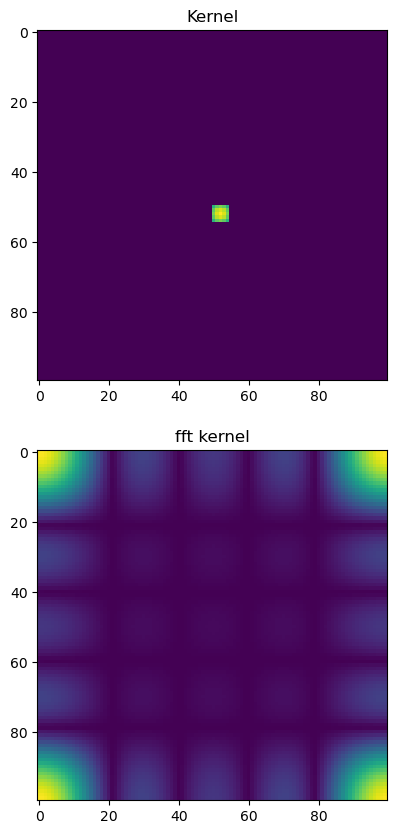

In [3]:
fig, axs = plt.subplots(2,1, figsize=(10,10))

kernel, kernel_tf = create_gauss_filter(100, 100, k_size=5, sigma=3)
axs[0].imshow(kernel)
axs[0].set_title("Kernel")
axs[1].imshow(abs(np.fft.fft2(kernel)))
axs[1].set_title("fft kernel")
plt.show()

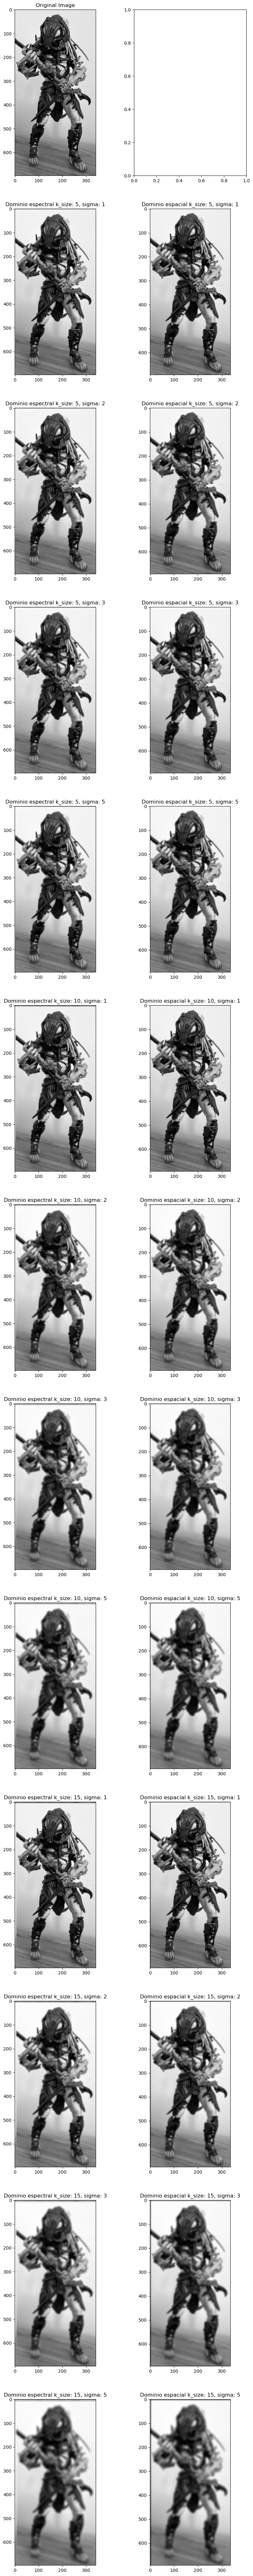

In [4]:
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
img_fft = np.fft.fft2(img)

h, w = img.shape
k_sizes = [5, 10, 15]
sigmas = [1, 2, 3, 5]

n_fig = len(k_sizes) * len(sigmas) + 1

fig, axs = plt.subplots(n_fig,2, figsize=(10 , 8*n_fig))

axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title('Original Image')

count = 1
for k_size in k_sizes:
    for sigma in sigmas:
        gaussian_filter, tf = create_gauss_filter(h, w, k_size=k_size, sigma=sigma)
        filter_img = img_fft * tf
        
        spacial = signal.fftconvolve(img, gaussian_filter, mode='same')
        
        img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filter_img)))
        
        axs[count, 0].imshow(img_gauss, cmap='gray')
        axs[count, 0].set_title(f'Dominio espectral k_size: {k_size}, sigma: {sigma}')

        axs[count, 1].imshow(spacial[5:,5:], cmap='gray')
        axs[count, 1].set_title(f'Dominio espacial k_size: {k_size}, sigma: {sigma}')
        
        count += 1

plt.show()

### Se puede observar que cuando el valor de sigma en grande el blur aumenta, y cuando el tamaño del kernel aumenta se van perdiendo los detalles 

# Punto 2
### Image sharpness measure for blurred images in frequency domain

In [5]:
def image_sharpness_measure(image):
    
    M, N = image.shape
    f = np.fft.fft2(image)  
    fc = np.fft.fftshift(f)  
    af = np.abs(fc) 
    m = np.max(f)  
    th = np.count_nonzero( f >= (m/1000) )
    fm = th / (M * N)

    return fm

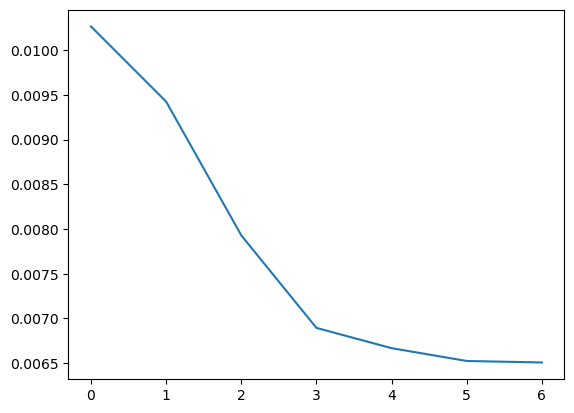

In [6]:
measures = []
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
measures.append(image_sharpness_measure(img))

h, w = img.shape

for sigma_i in [0.5, 1, 2, 3, 5, 8]:
    gaussian_filter, tf = create_gauss_filter(h, w, k_size=5, sigma=sigma_i)
    img_fft = np.fft.fft2(img)
    filter_img = img_fft * tf
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filter_img)))
    
    measures.append(image_sharpness_measure(img_gauss))

plt.plot(measures)
plt.show()

Cuando aumenta el valor de sigma aumenta el blur y por lo tanto la calidad de la imagen va disminuyendo.

# Punto 3
### Analysis of focus measure operators in shape-from-focus

A.20 Variance of Laplacian (LAP4)

In [7]:
def variance_of_laplacian(img):
    return cv.Laplacian(img, cv.CV_64F).var()

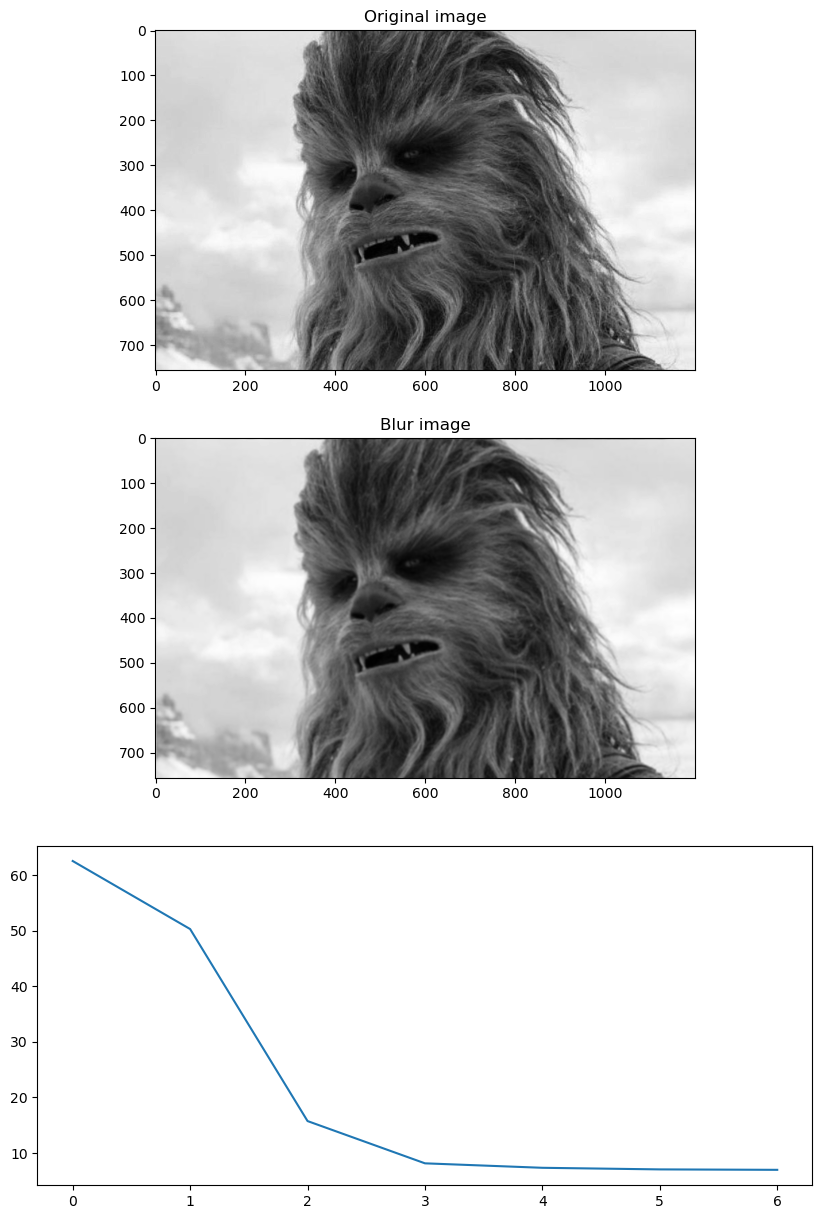

In [8]:
measures = []
img = cv.imread('chewbacca.jpg', cv.IMREAD_GRAYSCALE)
measures.append(variance_of_laplacian(img))

h, w = img.shape

for sigma_i in [0.5, 1, 2, 3, 5, 8]:
    gaussian_filter, tf = create_gauss_filter(h, w, k_size=5, sigma=sigma_i)
    img_fft = np.fft.fft2(img)
    filter_img = img_fft * tf
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filter_img)))
    
    measures.append(variance_of_laplacian(img_gauss))

fig, axs = plt.subplots(3,1, figsize=(10 , 15))    

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(img_gauss, cmap='gray')
axs[1].set_title('Blur image')
    
axs[2].plot(measures)
plt.show()

Con esta metrica "variance of laplacian" pasa igual que con "sharpness measure", a medida que el sigma aumenta el blur y por lo tanto disminuye la calidad de la imagen, se puede ver que en los primeros sigmas hay un descenso significativo y al final el descenso parece asintótico.